In [12]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# --- Config
IMAGE_DIR = "images"
CSV_FILE = "labels.csv"
IMG_SIZE = (224, 224)
EPOCHS = 50
BATCH_SIZE = 32

# --- Chargement du CSV
df = pd.read_csv(CSV_FILE, header=None, names=["filename", "x", "y", "style_cible"])

# --- Chargement et prétraitement des images
def preprocess_image(filename):
    path = os.path.join(IMAGE_DIR, filename)
    img = load_img(path, target_size=IMG_SIZE)
    img = img_to_array(img)
    return tf.keras.applications.mobilenet_v2.preprocess_input(img)

images = np.array([preprocess_image(fname) for fname in df["filename"]])
targets_xy = df[["x", "y"]].values.astype("float32") / [320, 240]  # (N,2)
targets_style = df["style_cible"].values.astype("float32").reshape(-1, 1)  # (N,1)
targets_all = np.concatenate([targets_xy, targets_style], axis=1)  # (N,3)

# --- Split unique
X_train, X_test, y_train_all, y_test_all = train_test_split(
    images, targets_all,
    test_size=0.2, stratify=targets_style, random_state=42
)

y_train_xy = y_train_all[:, :2]
y_train_style = y_train_all[:, 2].reshape(-1, 1)
y_test_xy = y_test_all[:, :2]
y_test_style = y_test_all[:, 2].reshape(-1, 1)

print("Train XY:", y_train_xy.shape)         # (N,2)
print("Train STYLE:", y_train_style.shape)   # (N,1)
print("Test XY:", y_test_xy.shape)           # (N,2)
print("Test STYLE:", y_test_style.shape)     # (N,1)

# --- Modèle : dictionnaire explicite
base_model = MobileNetV2(input_shape=(*IMG_SIZE, 3), include_top=False, weights="imagenet")
base_model.trainable = False

inputs = Input(shape=(*IMG_SIZE, 3), name="input_image")
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
xy_output = Dense(2, activation="sigmoid", name="xy_output")(x)
style_output = Dense(1, activation="sigmoid", name="style_output")(x)

model = Model(inputs=inputs, outputs={"xy_output": xy_output, "style_output": style_output})

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        "xy_output": "mse",
        "style_output": "binary_crossentropy"
    },
    loss_weights={
        "xy_output": 1.0,
        "style_output": 0.1
    },
    metrics={
        "xy_output": "mae",
        "style_output": "accuracy"
    }
)

model.summary()  # <--- pour voir les outputs et shapes

callbacks = [EarlyStopping(patience=5, restore_best_weights=True)]

# --- Vérifie shapes AVANT le fit :
print("X_train:", X_train.shape)
print("y_train_xy:", y_train_xy.shape)
print("y_train_style:", y_train_style.shape)

# --- Entraînement
history = model.fit(
    X_train,
    {"xy_output": y_train_xy, "style_output": y_train_style},
    validation_data=(X_test, {"xy_output": y_test_xy, "style_output": y_test_style}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

# --- Sauvegarde
model.save("mobilenetv2_xy_style_model.h5")


Train XY: (160, 2)
Train STYLE: (160, 1)
Test XY: (40, 2)
Test STYLE: (40, 1)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_image[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │     32,896 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ style_output        │ (None, 1)         │        129 │ dense_19[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xy_output (Dense)   │ (None, 2)         │        258 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,619,203 (9.99 MB)

 Trainable params: 361,219 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

X_train: (160, 224, 224, 3)
y_train_xy: (160, 2)
y_train_style: (160, 1)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 745ms/step - loss: 0.1157 - style_output_accuracy: 1.0000 - style_output_loss: 0.0241 - xy_output_loss: 0.0916 - xy_output_mae: 0.2400 - val_loss: 0.0621 - val_style_output_accuracy: 1.0000 - val_style_output_loss: 0.0125 - val_xy_output_loss: 0.0459 - val_xy_output_mae: 0.1898
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.0505 - style_output_accuracy: 1.0000 - style_output_loss: 0.0101 - xy_output_loss: 0.0404 - xy_output_mae: 0.1674 - val_loss: 0.0636 - val_style_output_accuracy: 1.0000 - val_style_output_loss: 0.0053 - val_xy_output_loss: 0.0529 - val_xy_output_mae: 0.1976
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - loss: 0.0411 - style_output_accuracy: 1.0000 - style_output_loss: 0.0044 - xy_output_loss: 0.0367 - xy_output_mae: 0.1525 - val_loss: 0.0407 - val_style_output_accuracy: 1.0000 - val_style_output_loss: 0.0026 - val_xy_output_loss: 0.0367 

In [14]:
# Prédictions sur les données de test (ATTENTION: dict de sorties !)
y_pred = model.predict(X_test)
# Si c'est un dict, on accède par nom
if isinstance(y_pred, dict):
    y_pred_xy = y_pred["xy_output"]
    y_pred_style = y_pred["style_output"]
else:
    # Sinon, tuple/list (plus rare avec compile en dict)
    y_pred_xy, y_pred_style = y_pred

# y_test_comb = y_test_all ! à reprendre si besoin
y_true_xy = y_test_all[:, :2]
y_true_style = y_test_all[:, 2]

y_pred_style_bin = (y_pred_style > 0.5).astype("float32").flatten()

from sklearn.metrics import mean_absolute_error, accuracy_score

# MAE sur x, y (normalisés → pixels)
mae_xy = mean_absolute_error(y_true_xy * [320, 240], y_pred_xy * [320, 240])
acc_style = accuracy_score(y_true_style, y_pred_style_bin)

print(f"🔢 MAE (x, y) : {mae_xy:.2f} pixels")
print(f"🎯 Précision style_cible : {acc_style:.2%}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
🔢 MAE (x, y) : 23.61 pixels
🎯 Précision style_cible : 100.00%


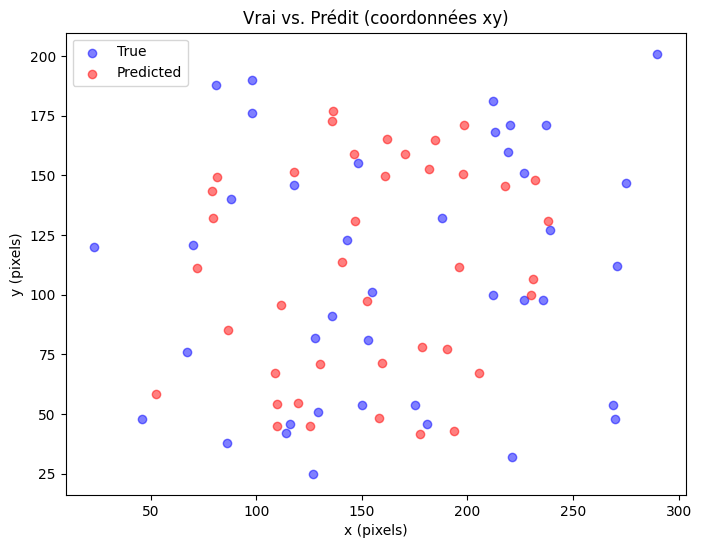

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true_xy[:, 0] * 320, y_true_xy[:, 1] * 240, c='blue', label='True', alpha=0.5)
plt.scatter(y_pred_xy[:, 0] * 320, y_pred_xy[:, 1] * 240, c='red', label='Predicted', alpha=0.5)
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')
plt.legend()
plt.title('Vrai vs. Prédit (coordonnées xy)')
plt.show()


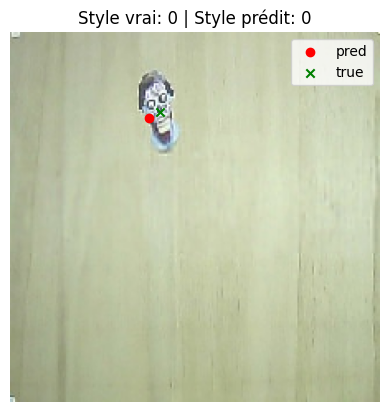

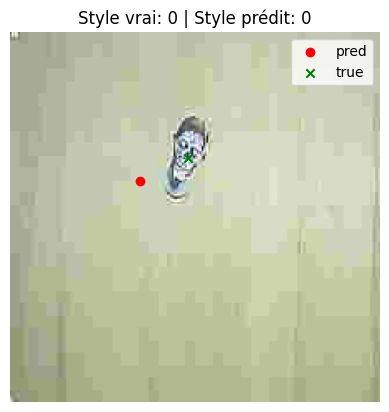

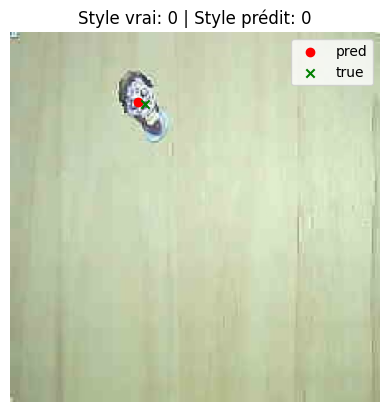

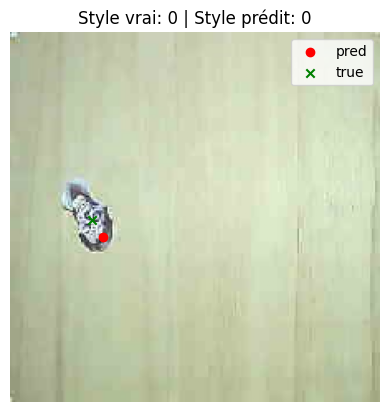

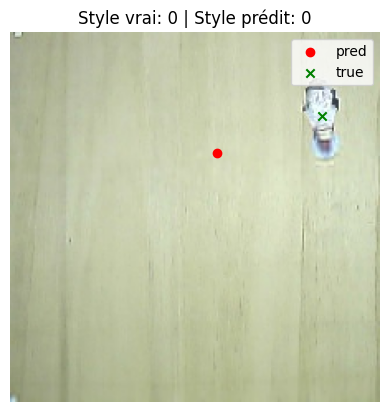

In [28]:
# Affichage sur quelques images
import matplotlib.pyplot as plt

def show_predictions(n=5):
    indices = np.random.choice(len(X_test), n, replace=False)
    for i in indices:
        img = X_test[i]
        true_xy = y_true_xy[i] * [224, 224]
        pred_xy = y_pred_xy[i] * [224, 224]
        true_style = int(y_true_style[i])
        pred_style = int(y_pred_style_bin[i])

        plt.imshow((img + 1) / 2)  # remise à l'échelle [-1,1] → [0,1]
        plt.scatter(*pred_xy, c="red", label="pred")
        plt.scatter(*true_xy, c="green", marker="x", label="true")
        plt.title(f"Style vrai: {true_style} | Style prédit: {pred_style}")
        plt.legend()
        plt.axis("off")
        plt.show()

# Afficher quelques prédictions
show_predictions(5)


In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1710471389100401999
xla_global_id: -1
]
